## Package version
- tensorflow==2.2.0rc3
- numpy==1.18.2
- matplotlib==3.2.1
- image==1.5.30
- google==2.0.3

# Import Tensorflow

In [31]:
import tensorflow
tensorflow.__version__

'2.2.0-rc3'

**Load any image**

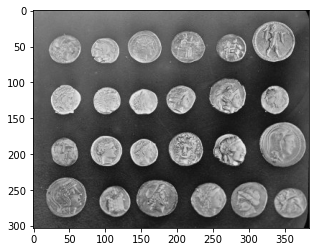

In [32]:
# skimage.data has a lot of sample images to play around with
from skimage import data
import matplotlib.pyplot as plt

image = data.coins()
plt.imshow(image, cmap='gray')

**Import utilities needed for convolution**

In [0]:
from scipy.signal import convolve2d

**Find the 5X5 Guassian Blur kernel with sigma = 1.0 and convolve the above image with that kernel**


*Hint: You can create various Guassian kernel at http://dev.theomader.com/gaussian-kernel-calculator/*

In [0]:
import numpy as np
kernel = np.array([[0.003765,0.015019,0.023792,0.015019,0.003765],
                   [0.015019,0.059912,0.094907,0.059912,0.015019],
                   [0.023792,0.094907,0.150342,0.094907,0.023792],
                   [0.015019,0.059912,0.094907,0.059912,0.015019],
                   [0.003765,0.015019,0.023792,0.015019,0.003765]])

**Convole the guassian kernel with the image and use 'valid' convolution and show the result side by side**

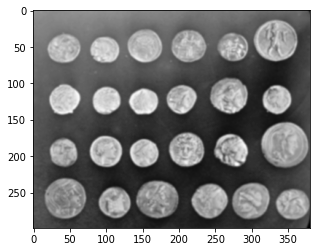

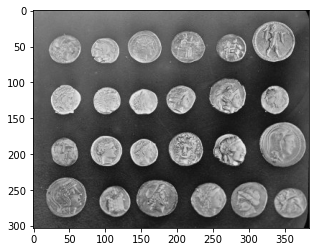

In [35]:
from scipy.signal import convolve2d
blurred_image = convolve2d(image, kernel, mode = 'valid')
plt.imshow(blurred_image,cmap='gray')
plt.show()
plt.imshow(image,cmap='gray')

<h1>Build a CNN to classify 10 monkey species</h1>

**Mounting Google Drive on to the Google Colab instance**

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Set the appropriate path for the datsaet zip provided**

In [0]:
images_path = "/content/drive/My Drive/monkeys_dataset.zip"

**Extracting the dataset.zip to the present working directory**

In [0]:
from zipfile import ZipFile
with ZipFile(images_path, 'r') as zip:
  zip.extractall()

*Check the list of files in the pwd(present working directory) by running command 'ls' and ensure 'dataset' folder has been generated*

In [39]:
!ls

classifier.h5  classifier_weights.h5  dataset  drive  sample_data


**Build a Sequential CNN classifier with input shape as 64X64 and using three sets of Convoltutional + Pooling layers. You can additionally use Dropout in the fully connected layers. Make sure the final layer shape matches with the number of classes**

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Initialising the CNN classifier
classifier = Sequential()

# Add a Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu', padding = 'same'))

# Add a Max Pooling layer of size 2X2
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Add another Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
classifier.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))

# Adding another pooling layer
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Add another Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
classifier.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'valid'))

# Adding another pooling layer
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Flattening the layer before fully connected layers
classifier.add(Flatten())

# Adding a fully connected layer with 512 neurons
classifier.add(Dense(units = 512, activation = 'relu'))

# Adding dropout with probability 0.5
classifier.add(Dropout(0.5))


# Adding a fully connected layer with 128 neurons
classifier.add(Dense(units = 128, activation = 'relu'))


# The final output layer with 10 neurons to predict the categorical classifcation
classifier.add(Dense(units = 10, activation = 'softmax'))

**Compile the CNN classifier with Adam optimizer (default Learning rate and other parameters)
and Categorical Crossentropy as loss function and Accuracy as the metric to monitor**

*Optionally you can use an optimizer with custom learning rate and passing it to the optimizer parameter of compile*

*Eg: tensorflow.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)*

In [0]:
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

**Use ImageDataGenerator to create a test and training set data generators and use fit_generator() function to train the model**

*ImageDataGenerator is a powerful preprocessing utility to generate training and 
testing data with common data augmentation techniques. It can also be used to  
generate training data from Images stored in hierarchical directory structures
For more options of ImageDataGenerator go to https://keras.io/preprocessing/image/*

In [42]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create data generator for training data with data augmentation and normalizing all
# values by 255
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


test_datagen = ImageDataGenerator(rescale = 1./255)

# Setting training data generator's source directory
# Setting the target size to resize all the images to (64,64) as the model input layer expects 64X64 images

training_set = train_datagen.flow_from_directory('./dataset/train',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

# Setting testing data generator's source directory
test_set = test_datagen.flow_from_directory('./dataset/test',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')


# There are 1098 training images and 272 test images in total
classifier.fit_generator(training_set,
                         steps_per_epoch = int(1098/32),
                         epochs = 1,
                         validation_data = test_set,
                         validation_steps = int(272/32))


Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.
34/34 [==============================] - 38s 1s/step - loss: 2.2958 - accuracy: 0.1471 - val_loss: 2.2120 - val_accuracy: 0.2070


**save the model and its weights**

In [0]:
classifier.save('./classifier.h5')
classifier.save_weights('./classifier_weights.h5')

*Check the current directory if the weights have been saved*

In [44]:
!ls

classifier.h5  classifier_weights.h5  dataset  drive  sample_data


<h2>Testing the model</h2>

**Load the pre-trained saved model and load the weights**

In [0]:
from tensorflow.keras.models import load_model

# Load the pre trained model from the HDF5 file saved previously
pretrained_model = load_model('./classifier.h5')
pretrained_model.load_weights('./classifier_weights.h5')

**Test the model on one single image from the test folders**

In [46]:
import cv2
test_image = cv2.imread('/content/dataset/test/n0/n000.jpg')


# Check if the size of the Image array is compatible with Keras model
print(test_image.shape)

# Reshape the image to 64x64x3
test_image = cv2.resize(test_image, (64, 64))
print(test_image.shape)

# If not compatible expand the dimensions to match with the Keras Input
test_image = np.expand_dims(test_image, axis = 0)
test_image =test_image*1/255.0

#Check the size of the Image array again
print('After expand_dims: '+ str(test_image.shape))


#Predict the result of the test image
result = classifier.predict(test_image)

# Check the indices Image Data Generator has allotted to each folder
classes_dict = training_set.class_indices
print(classes_dict)

# Creating a list of classes in test set for showing the result as the folder name
prediction_class = []
for class_name,index in classes_dict.items():
  prediction_class.append(class_name)
  
print(result[0])

# Index of the class with maximum probability
predicted_index = np.argmax(result[0])

# Print the name of the class
print(prediction_class[predicted_index])

(331, 500, 3)
(64, 64, 3)
After expand_dims: (1, 64, 64, 3)
{'n0': 0, 'n1': 1, 'n2': 2, 'n3': 3, 'n4': 4, 'n5': 5, 'n6': 6, 'n7': 7, 'n8': 8, 'n9': 9}
[0.11890665 0.0843783  0.08120754 0.18248226 0.08211511 0.10593714
 0.07660571 0.08192824 0.07960276 0.1068363 ]
n3


**Play around with the model by adding regularization to the layers, adding more convolutional layers, etc., to improve the testing accuracy**